<div class="alert alert-block alert-info">
<center> <h1> BUSINESS CASES FOR DATA SCIENCE</h1> </center> <br>
<center> BC3: Gift-a-Lot recommender system 2021/2022 </center>

**GROUP AC:**    <br> 
- Beatriz Neto (20210608) <br>
- Rodrigo Joaquim (20211024) <br>
- Sara Silva (20210619)

<hr>
<a class="anchor" id="import">
    
# 1. Imports
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import math
import random

import plotly.graph_objects as go
import plotly.express as px

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import coo_matrix

#!pip install implicit
from implicit.als import AlternatingLeastSquares

#!pip install nmslib
import nmslib

#! pip install fpgrowth_py
from fpgrowth_py import fpgrowth

import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
import networkx as nx
from matplotlib.ticker import PercentFormatter
from mlxtend.preprocessing import TransactionEncoder

from sklearn.preprocessing import MinMaxScaler

import implicit

from implicit.evaluation import ranking_metrics_at_k

import time

<a class="anchor" id="importdatasets">

## 1.2. Import Dataset

</a>

In [1]:
path = 'https://raw.githubusercontent.com/joaopfonseca/business-cases-21-22/main/BC3_recommendation_system/'

gift = pd.read_csv(path + 'retail.csv')
gift.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
gift.shape

(541909, 8)

<hr>
<a class="anchor" id="datapreparation">
    
# 2. Data Preparation
    
</a>

### -  Explore Datatypes

In [5]:
gift.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
# change wrong datatypes
gift['InvoiceDate'] = pd.to_datetime(gift['InvoiceDate'])

### -  Cancellations

In [7]:
# save cancellations in another dataframe
df_cancellations = gift[gift['InvoiceNo'].str.startswith('C')]

In [8]:
df_cancellations.shape[0]

9288

In [9]:
print('Percentage of cancellations in the dataset:', np.round((df_cancellations.shape[0]/gift.shape[0])*100,2), '%')

Percentage of cancellations in the dataset: 1.71 %


In [10]:
# dataframe without cancellations
gift = gift[~(gift['InvoiceNo'].str.startswith('C'))]

In [11]:
gift.shape[0]

532621

### - Non product transactions

In [12]:
# remove don't product transactions from the dataset since they are not needed for the context of the study

transactions_code = ['BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST', 'B', 'm']

gift[gift['StockCode'].isin(transactions_code)].shape[0]

2328

In [13]:
print('Percentage of non product transactions in the dataset:', np.round((gift[gift['StockCode'].isin(transactions_code)].shape[0]/gift.shape[0])*100,2), '%')

Percentage of non product transactions in the dataset: 0.44 %


In [14]:
# remove rows with those observations from the the dataset

gift = gift[~(gift['StockCode'].isin(transactions_code))]

In [15]:
# remove rows that the transactions are gifts

gift = gift[~(gift['StockCode'].str.contains('gift'))]

### - Check & Treat Duplicates

In [16]:
gift_duplicates = gift.copy()

In [17]:
#instead of droping the duplicates we summed the quantity of that duplicated rows
gift_duplicates = gift.copy()

duplicates = gift_duplicates[gift_duplicates.duplicated(keep=False)]

duplicates = duplicates.groupby(list(duplicates.columns), as_index=False)['Quantity'].sum()

not_duplicates = gift_duplicates[~gift_duplicates.duplicated(keep=False)]

gift_duplicates = pd.concat([not_duplicates, duplicates], axis= 0).sort_index()

In [18]:
gift_duplicates.drop_duplicates(inplace=True)

In [19]:
# number of rows left in the dataset
gift_duplicates.shape[0]

524843

In [20]:
gift_duplicates[gift_duplicates.duplicated()]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

<a class="anchor" id="descripstat">

## 2.1. Descriptive Statistics

</a>

In [21]:
gift_duplicates.describe().T

count          mean          std      min       25%       50%  \
Quantity    524843.0     10.360102   160.740896  -9600.0      1.00      4.00   
UnitPrice   524843.0      3.285224    19.198024      0.0      1.25      2.08   
CustomerID  391031.0  15294.841199  1710.335201  12346.0  13969.00  15157.00   

                 75%       max  
Quantity       12.00  80995.00  
UnitPrice       4.13  13541.33  
CustomerID  16794.00  18287.00

<a class="anchor" id="#incoherencechecking">

## 2.2. Incoherence Checking

</a>

In [22]:
gift_ic = gift_duplicates.copy()

### 1) Negative or zero unit price values

In [23]:
# We can't have unit prices of zero or negative pounds

nr_price_incoherence = gift_ic[gift_ic['UnitPrice'] <= 0].shape[0]
nr_price_incoherence

2487

In [24]:
gift_ic[gift_ic['UnitPrice'] <= 0].head(5)

InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  \
622     536414     22139         NaN        56 2010-12-01 11:52:00        0.0   
1970    536545     21134         NaN         1 2010-12-01 14:32:00        0.0   
1971    536546     22145         NaN         1 2010-12-01 14:33:00        0.0   
1972    536547     37509         NaN         1 2010-12-01 14:33:00        0.0   
1987    536549    85226A         NaN         1 2010-12-01 14:34:00        0.0   

      CustomerID         Country  
622          NaN  United Kingdom  
1970         NaN  United Kingdom  
1971         NaN  United Kingdom  
1972         NaN  United Kingdom  
1987         NaN  United Kingdom

In [25]:
print('Percentage of UnitPrice incoherences in the dataset:', np.round((nr_price_incoherence/gift_ic.shape[0])*100,2), '%')

Percentage of UnitPrice incoherences in the dataset: 0.47 %


In [26]:
# drop rows with this incoherence

gift_ic = gift_ic[~(gift_ic['UnitPrice'] <= 0)]

<a class="anchor" id="missval">

## 2.3. Missing Values

</a>

In [27]:
gift_mv = gift_ic.copy()

In [28]:
# there is nan values in the customer id column

gift_mv.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131358
Country             0
dtype: int64

In [29]:
customer_mv = gift_mv['CustomerID'].isna().sum()

In [30]:
print('percentage of missing values in the dataset:', np.round((customer_mv/gift.shape[0])*100,2), '%')

percentage of missing values in the dataset: 24.77 %


In [31]:
#creating a data frame with only the new customers
gift_new = gift_mv.loc[gift_mv['CustomerID'].isna()]

In [32]:
#creating a data frame with only the frequent customers
gift_mv = gift_mv.loc[~gift_mv['CustomerID'].isna()]

In [33]:
# creating a data frame with only the new customers
gift_mv.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [34]:
# change CustomerID datatype to integer
gift_mv['CustomerID'] = gift_mv['CustomerID'].astype('int64')

<hr>
<a class="anchor" id="engineering">
    
# 3. Data Engineering
    
</a>

In [35]:
gift_eng = gift_mv.copy().sort_values(by='InvoiceDate').reset_index(drop=True)

In [36]:
# Dividing the InvoiceDate in Month, day
gift_eng['Date_month'] = gift_eng['InvoiceDate'].dt.month
gift_eng['Date_day'] = gift_eng['InvoiceDate'].dt.day

In [37]:
#list with countries
lista = gift_eng['Country'].unique()

In [38]:
#correcting the UK name 
gift_eng['Country'].replace('United Kingdo', 'United Kingdom', inplace=True)

In [39]:
#creating the South and North Hemispheric 
north_hemispheric = ['United Kingdom', 'France', 'Netherlands', 'Germany','Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal','Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland', 'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland','Austria','Bahrain', 'Israel', 'Greece', 'Hong Kong','Singapore','Lebanon', 'United Arab Emirates', 'Saudi Arabia',
 'Czech Republic', 'Canada', 'Unspecified', 'USA','European Community', 'Malta']

south_hemispheric = ['Australia', 'Brazil']

def hemispheric(row):
    if row['Country'] in north_hemispheric:
        return 1
    else:
        return 0

gift_eng['Hemispheric'] = gift_eng.apply(lambda row: hemispheric(row), axis = 1)

In [40]:
# creating Season variable for the North Hemispheric

def season(row):
    if row['Date_month'] in [4, 5] \
    or (row['Date_month'] == 3 and row['Date_day'] >= 20) \
    or (row['Date_month'] == 6 and row['Date_day'] < 21):
        return 'Spring'
    elif row['Date_month'] in [7, 8] \
    or (row['Date_month'] == 6 and row['Date_day'] >= 21) \
    or (row['Date_month'] == 9 and row['Date_day'] < 22):
        return 'Summer'
    elif row['Date_month'] in [10, 11] \
    or (row['Date_month'] == 9 and row['Date_day'] >= 22) \
    or (row['Date_month'] == 12 and row['Date_day'] < 21):
        return 'Autumn'
    else:
        return 'Winter'
    
gift_eng['Season'] = gift_eng[gift_eng['Hemispheric']==1].apply(lambda row: season(row), axis = 1)

In [41]:
# Transforming Season variable for the South Hemispheric

def season(row):
    if row['Date_month'] in [10, 11] \
    or (row['Date_month'] == 9 and row['Date_day'] >= 22) \
    or (row['Date_month'] == 12 and row['Date_day'] < 22):
        return 'Spring'
    elif row['Date_month'] in [1, 2] \
    or (row['Date_month'] == 12 and row['Date_day'] >= 20) \
    or (row['Date_month'] == 3 and row['Date_day'] < 21):
        return 'Summer'
    elif row['Date_month'] in [4, 5] \
    or (row['Date_month'] == 3 and row['Date_day'] >= 21) \
    or (row['Date_month'] == 6 and row['Date_day'] < 22):
        return 'Autumn'
    else:
        return 'Winter'

gift_eng['Season'].fillna(gift_eng[gift_eng['Hemispheric']==0].apply(lambda row: season(row), axis = 1), inplace=True)

In [42]:
gift_eng.drop(['Hemispheric', 'Date_month', 'Date_day'], axis=1, inplace=True)

<hr>
<a class="anchor" id="eda">
    
# 4. Exploratory Data Analysis
    
</a>

<a class="anchor" id="amount">

## 4.1. Amount of transactions per country of origin

</a>

In [43]:
gift_analysis = gift_ic.copy()

In [44]:
country_pop=pd.DataFrame(gift_analysis.groupby('Country').agg(Transactions=('Country','count'))).reset_index()
country_pop.head()

Country  Transactions
0  Australia          1180
1    Austria           384
2    Bahrain            18
3    Belgium          1935
4     Brazil            32

In [45]:
# Plotting a pie chart to see the percentage of transactions for each country 
fig = px.pie(country_pop, values='Transactions', names='Country',
             title='Number of Transactions per Country',
             hover_data=['Country'], labels={'Transactions'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [46]:
# Creating a data frame to show the percentage of purchases by country
countries_count=gift_analysis.groupby('Country').Country.agg('count')
list3=list(countries_count.index)
list4=list(countries_count.values)
df_countries_count= pd.DataFrame(list(zip(list3, list4)),columns =['Country', 'Nr of purchases']).sort_values(by='Nr of purchases',ascending=False)
df_countries_count['Percentage']=(df_countries_count['Nr of purchases']/sum(df_countries_count['Nr of purchases']))*100
df_countries_count.head(5)

Country  Nr of purchases  Percentage
36  United Kingdom           478704   91.643247
14         Germany             8643    1.654619
13          France             8085    1.547795
10            EIRE             7767    1.486917
31           Spain             2417    0.462711

<a class="anchor" id="cancelledprod">

## 4.2. Top 10 Cancelled Products

</a>

In [47]:
df_cancellations = df_cancellations[~(df_cancellations['StockCode'].isin(transactions_code))]

In [48]:
#Top 10 products that were cancelled
df_cancellations.groupby('Description').Description.agg('count').nlargest(10)

Description
REGENCY CAKESTAND 3 TIER              181
JAM MAKING SET WITH JARS               87
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
JUMBO BAG RED RETROSPOT                44
LUNCH BAG RED RETROSPOT                44
Name: Description, dtype: int64

<a class="anchor" id="cancellednotcancelled">

## 4.3. Amount lost with cancellations

</a>

In [49]:
# Turning negative quantities into positive
pos_quant=np.abs(df_cancellations['Quantity'])
df_cancellations['Positive Quantity']=pos_quant
df_cancellations

InvoiceNo StockCode                        Description  Quantity  \
154      C536383    35004C    SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238      C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
...          ...       ...                                ...       ...   
540448   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978   HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  \
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom   
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom   
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
238    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
...                    ...        ...         ...             ...   
540448 2011-12-09 09:57:00       1.95     14397.0  United Kingdom   
540449 2011-12-09 09:57:00       0.83     14397.0  United Kingdom   
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom   
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom   
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom   

        Positive Quantity  
154                     1  
235                    12  
236                    24  
237                    24  
238                    24  
...                   ...  
540448                 12  
540449                 11  
541715                  5  
541716                  1  
541717                  5  

[8797 rows x 9 columns]

In [50]:
#Creating the column total to see the amount spent by items purchased
df_cancellations['total'] = df_cancellations['Positive Quantity']*df_cancellations['UnitPrice']
df_cancellations

InvoiceNo StockCode                        Description  Quantity  \
154      C536383    35004C    SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238      C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
...          ...       ...                                ...       ...   
540448   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978   HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  \
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom   
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom   
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
238    2010-12-01 10:24:00       0.29     17548.0  United Kingdom   
...                    ...        ...         ...             ...   
540448 2011-12-09 09:57:00       1.95     14397.0  United Kingdom   
540449 2011-12-09 09:57:00       0.83     14397.0  United Kingdom   
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom   
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom   
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom   

        Positive Quantity  total  
154                     1   4.65  
235                    12  19.80  
236                    24   6.96  
237                    24   6.96  
238                    24   6.96  
...                   ...    ...  
540448                 12  23.40  
540449                 11   9.13  
541715                  5  54.75  
541716                  1   1.25  
541717                  5   6.25  

[8797 rows x 10 columns]

In [51]:
# Value in pounds of the cancelled products 
total_cancelled=df_cancellations['total'].sum().round(2)
total_cancelled

717118.21

<a class="anchor" id="top_prod">

## 4.4. Top 10 Products

</a>

In [52]:
#Creating a dataframe with the top 10 items purchased
m2 = gift_analysis.groupby(['StockCode', 'Quantity']).agg(Total=('Quantity', 'count')).reset_index()
m2['Quantity'] = m2['Quantity']*m2['Total']
p2=pd.DataFrame( m2.groupby(['StockCode'])['Quantity'].sum()).sort_values(by='Quantity',ascending=False)
p2.head(10)

Quantity
StockCode          
23843         80995
23166         78033
22197         56915
84077         55047
85099B        48474
85123A        37660
84879         36461
21212         36415
23084         30786
22492         26633

In [53]:
# Associating the description to the stock code
gift_analysis[['Description', 'StockCode']].loc[gift_analysis['StockCode'].isin(p2[:10].index)].drop_duplicates()

Description StockCode
0       WHITE HANGING HEART T-LIGHT HOLDER    85123A
9            ASSORTED COLOUR BIRD ORNAMENT     84879
44                 MINI PAINT SET VINTAGE      22492
96         PACK OF 72 RETROSPOT CAKE CASES     21212
177                JUMBO BAG RED RETROSPOT    85099B
221                   SMALL POPCORN HOLDER     22197
1580                    RABBIT NIGHT LIGHT     23084
2784     WORLD WAR 2 GLIDERS ASSTD DESIGNS     84077
3239                        POPCORN HOLDER     22197
61619       MEDIUM CERAMIC TOP STORAGE JAR     23166
537621  CREAM HANGING HEART T-LIGHT HOLDER    85123A
540421         PAPER CRAFT , LITTLE BIRDIE     23843

<a class="anchor" id="rfm">

## 5. RFM Analysis

</a>

In [54]:
gift_rfm=gift_eng.copy()

In [55]:
# Code retrieved from: https://www.kaggle.com/code/mustafacicek/marketing-analytics-rfm-analysis
# Finding the begining date and the last date

gift_rfm['InvoiceDate'] = pd.to_datetime(gift_rfm['InvoiceDate'])

print("Min date: {} \nMax date: {}".format(gift_rfm.InvoiceDate.min(), gift_rfm.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [56]:
last_day = gift_rfm.InvoiceDate.max() + dt.timedelta(days = 1)
last_day

Timestamp('2011-12-10 12:50:00')

In [57]:
# Defining the gross amount of each item purchase
gift_rfm['Gross_Amount']=gift_rfm['Quantity']*gift_rfm['UnitPrice']

In [58]:
# Creating a groupby to get the recency, frequency and monetary of each client
table_rfm = gift_rfm.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                          "InvoiceNo": "nunique",
                                          "Gross_Amount": "sum"})

table_rfm.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "Gross_Amount": "Monetary"}, inplace = True)

table_rfm.head()

Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1437.24
12349            19          1   1457.55
12350           310          1    294.40

In [59]:
#Separatin RFM in ranks

r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

table_rfm["R"] = pd.qcut(table_rfm["Recency"], 5, labels = r_labels)
table_rfm["F"] = pd.qcut(table_rfm["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
table_rfm["M"] = pd.qcut(table_rfm["Monetary"], 5, labels = fm_labels)

table_rfm.head()

Recency  Frequency  Monetary  R  F  M
CustomerID                                       
12346           326          1  77183.60  1  1  5
12347             2          7   4310.00  5  5  5
12348            75          4   1437.24  2  4  4
12349            19          1   1457.55  4  1  4
12350           310          1    294.40  1  1  2

In [60]:
# Finding the RFM Score
table_rfm["RFM_Segment"] = table_rfm["R"].astype(str) + table_rfm["F"].astype(str) + table_rfm["M"].astype(str)
table_rfm["RFM_Score"] = table_rfm[["R", "F", "M"]].sum(axis = 1)

table_rfm.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
CustomerID                                                              
12346           326          1  77183.60  1  1  5         115          7
12347             2          7   4310.00  5  5  5         555         15
12348            75          4   1437.24  2  4  4         244         10
12349            19          1   1457.55  4  1  4         414          9
12350           310          1    294.40  1  1  2         112          4

Champions: Bought recently, buy often and spend the most

Loyal customers: Buy on a regular basis. Responsive to promotions.

Potential loyalist: Recent customers with average frequency.

Recent customers: Bought most recently, but not often.

Promising: Recent shoppers, but haven’t spent much.

Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.

About to sleep: Below average recency and frequency. Will lose them if not reactivated.

At risk: Some time since they’ve purchased. Need to bring them back!

Can’t lose them: Used to purchase frequently but haven’t returned for a long time.

Hibernating: Last purchase was long back and low number of orders. May be lost.

In [61]:
# Segmenting the clients by groups
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
table_rfm['Segment'] = table_rfm['R'].astype(str) + table_rfm['F'].astype(str)
table_rfm['Segment'] = table_rfm['Segment'].replace(segt_map, regex=True)
table_rfm.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                 
12346           326          1  77183.60  1  1  5         115          7   
12347             2          7   4310.00  5  5  5         555         15   
12348            75          4   1437.24  2  4  4         244         10   
12349            19          1   1457.55  4  1  4         414          9   
12350           310          1    294.40  1  1  2         112          4   

                Segment  
CustomerID               
12346       Hibernating  
12347         Champions  
12348           At-Risk  
12349         Promising  
12350       Hibernating

In [62]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

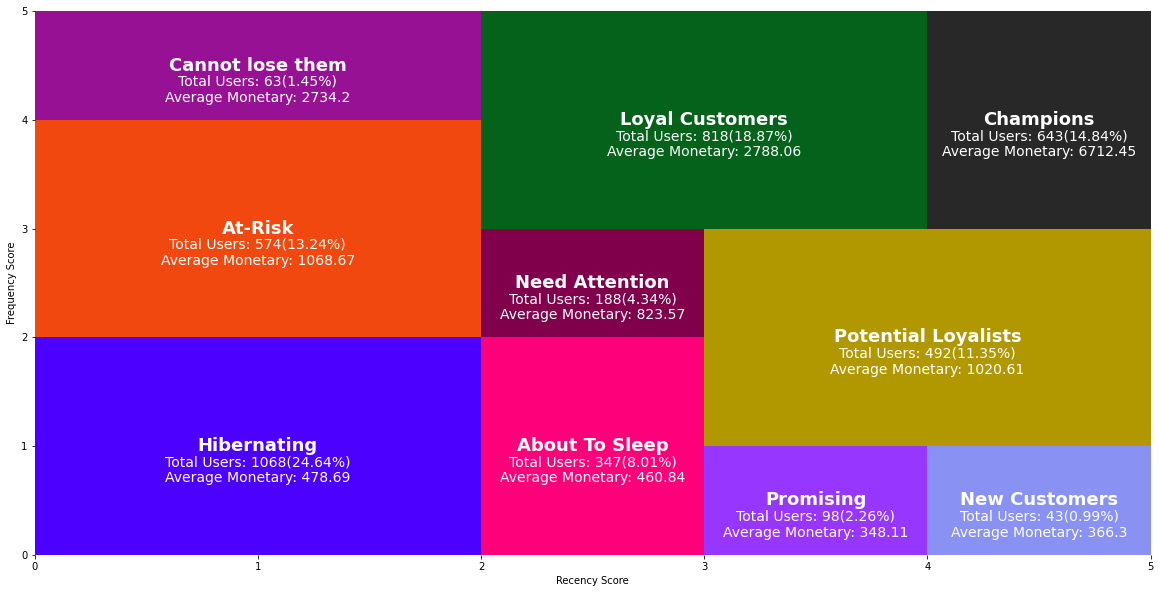

In [63]:
# Defining a function that returns a graph with all the customer groups


fig, ax = plt.subplots(figsize = (20, 10))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = table_rfm[table_rfm.Segment == key].shape[0]
    users_percentage = (table_rfm[table_rfm.Segment == key].shape[0] / table_rfm.shape[0]) * 100
    avg_monetary = table_rfm[table_rfm.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

In [64]:
table_rfm.reset_index(drop=False,inplace=True)
table_rfm.head()

CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
0       12346      326          1  77183.60  1  1  5         115          7   
1       12347        2          7   4310.00  5  5  5         555         15   
2       12348       75          4   1437.24  2  4  4         244         10   
3       12349       19          1   1457.55  4  1  4         414          9   
4       12350      310          1    294.40  1  1  2         112          4   

       Segment  
0  Hibernating  
1    Champions  
2      At-Risk  
3    Promising  
4  Hibernating

In [65]:
# Getting the number of days since the last transaction
gift_rfm['Recent_Transaction']=(gift_rfm.InvoiceDate.max()-gift_rfm.InvoiceDate).dt.days

In [66]:
# Extracting the monetary column from the table_rfm
monetary=table_rfm[['CustomerID', 'Monetary']]
monetary.head()

CustomerID  Monetary
0       12346  77183.60
1       12347   4310.00
2       12348   1437.24
3       12349   1457.55
4       12350    294.40

In [67]:
#Finding the number of transactions by client
nr_transactions=gift_rfm.groupby('CustomerID')['InvoiceNo'].count().reset_index()
nr_transactions.head()

CustomerID  InvoiceNo
0       12346          1
1       12347        182
2       12348         27
3       12349         72
4       12350         16

In [68]:
# Extracting the number of days since last transaction by CustomerID and Country
lt=gift_rfm.groupby(['CustomerID','Country'])['Recent_Transaction'].max().reset_index()
lt.head()

CustomerID         Country  Recent_Transaction
0       12346  United Kingdom                 325
1       12347         Iceland                 366
2       12348         Finland                 357
3       12349           Italy                  18
4       12350          Norway                 309

In [69]:
# Merging all of the previous dataframes
merge1= pd.merge(lt, nr_transactions, how='inner', on='CustomerID')
new_df=pd.merge(merge1,monetary,how='inner',on= 'CustomerID')
new_df.head()

CustomerID         Country  Recent_Transaction  InvoiceNo  Monetary
0       12346  United Kingdom                 325          1  77183.60
1       12347         Iceland                 366        182   4310.00
2       12348         Finland                 357         27   1437.24
3       12349           Italy                  18         72   1457.55
4       12350          Norway                 309         16    294.40

### Total maximum amount by country

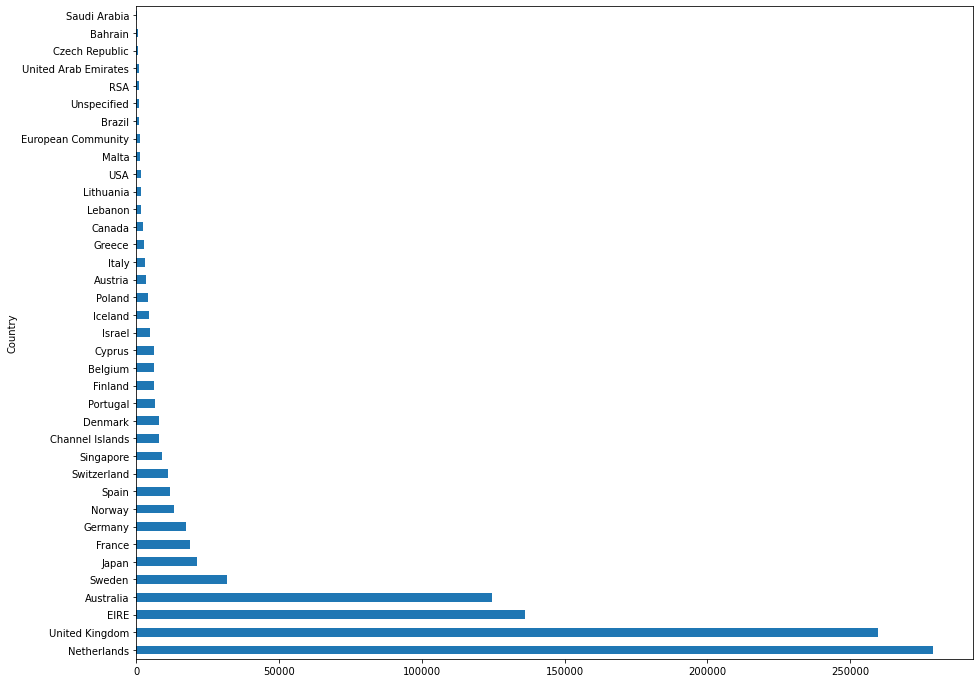

In [70]:
plt.figure(figsize=(15,12))
new_df.groupby("Country").Monetary.max().sort_values(ascending=False).plot.barh()
plt.show()

### Total minimum amount by country

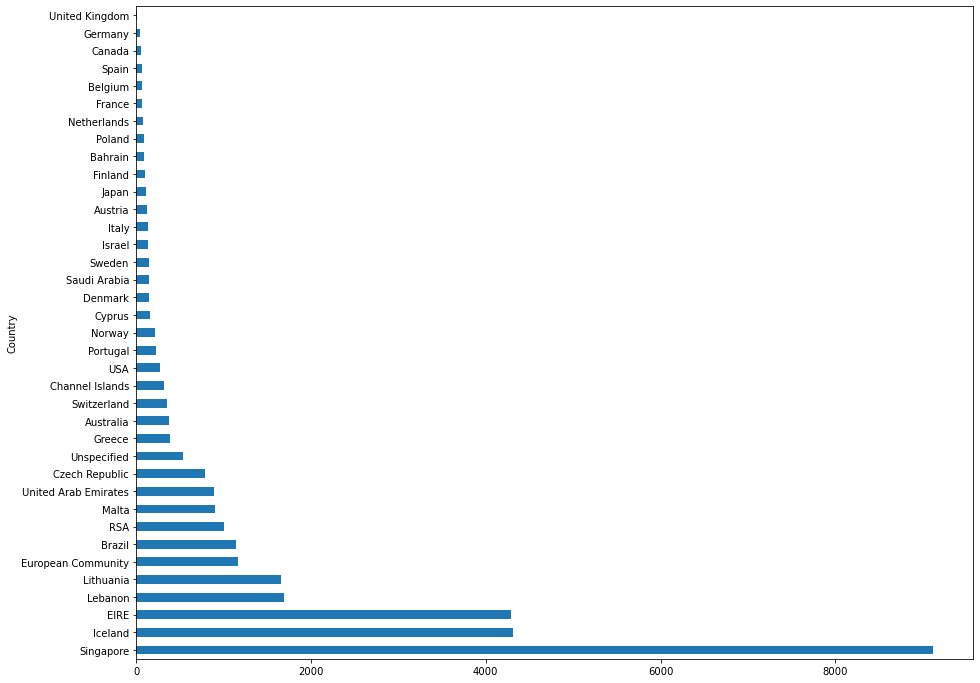

In [71]:
plt.figure(figsize=(15,12))
new_df.groupby("Country").Monetary.min().sort_values(ascending=False).plot.barh()
plt.show()

### Frequency  by country

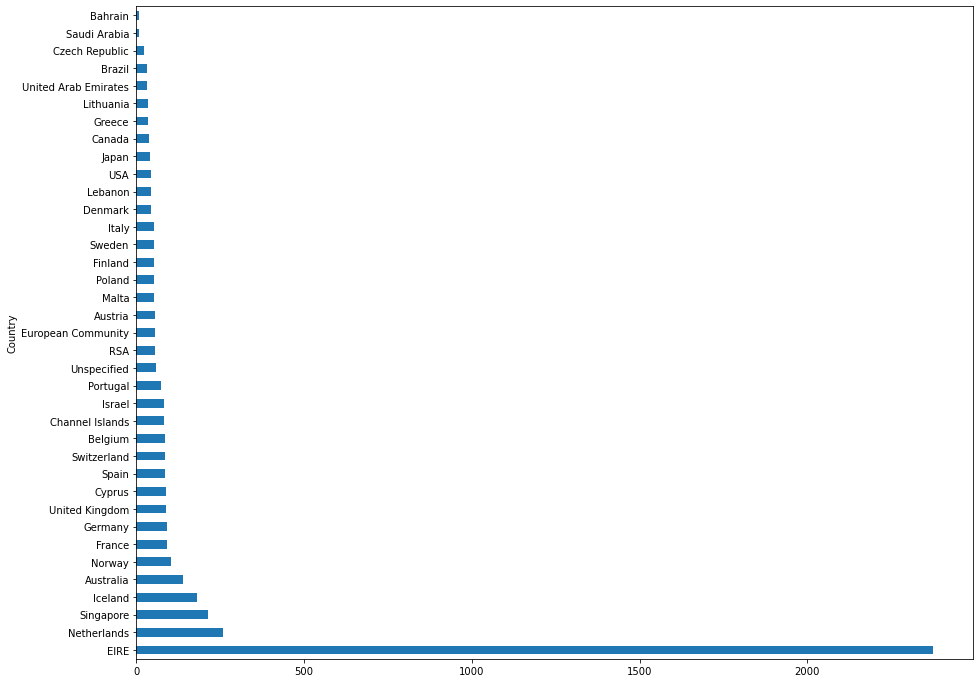

In [72]:
plt.figure(figsize=(15,12))
new_df.groupby("Country").InvoiceNo.mean().sort_values(ascending=False).plot.barh()
plt.show()

### Most Recent Country to Purchase

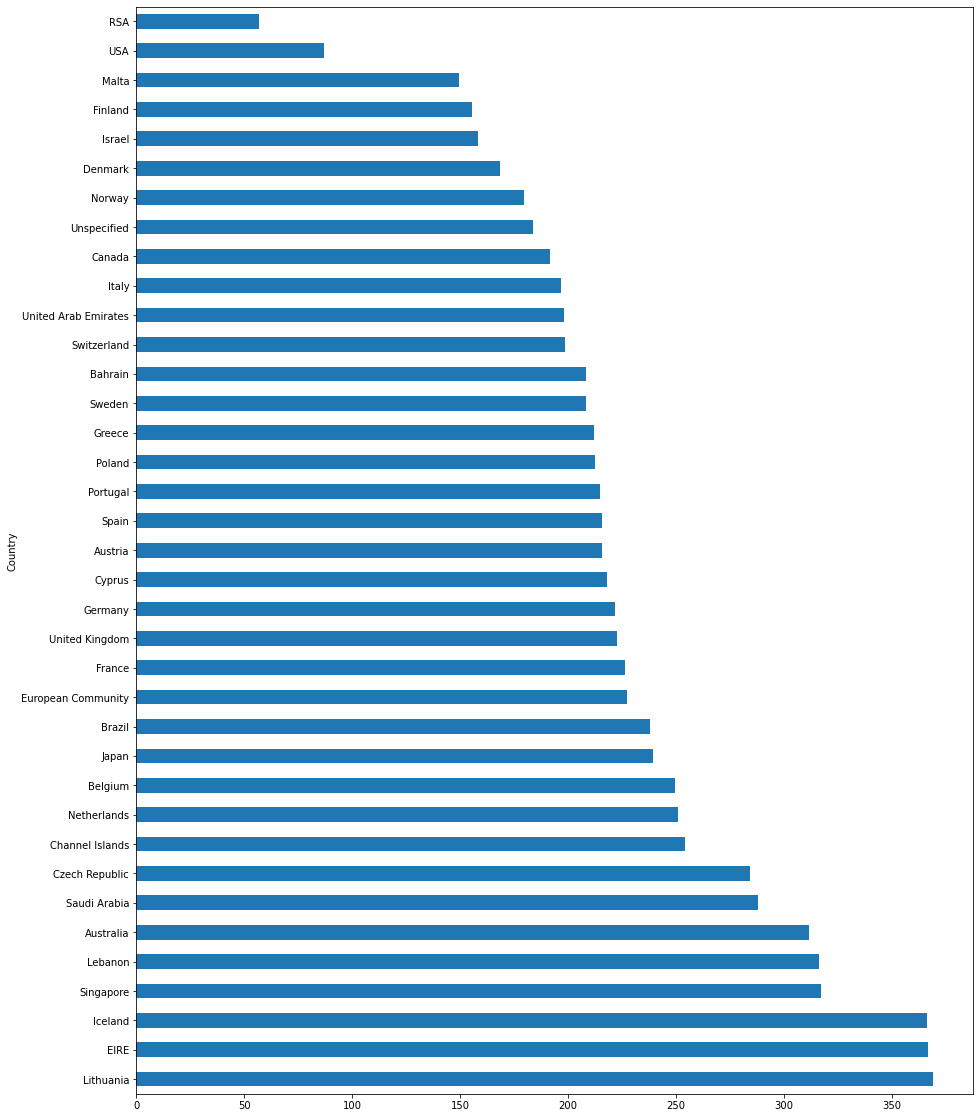

In [73]:
plt.figure(figsize=(15,20))
new_df.groupby("Country").Recent_Transaction.mean().sort_values(ascending=False).plot.barh()
plt.show()

<a class="anchor" id="pareto">

## 4.6. Pareto Principle

</a>

In [74]:
#pareto=gift.copy()
pareto=gift_eng.copy()

In [75]:
#Defining a column that gives the total price of each purchase
pareto['TotalPrice']=pareto['Quantity']*pareto['UnitPrice']

In [76]:
# Code retrieved from : https://www.kaggle.com/code/mustafacicek/marketing-analytics-pareto-principle
# Define a function that creates a column with the cumulative percentage of the prices

def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["CumulativePercentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

In [77]:
# Defining a function that returns a pareto plot when receiving a dataframe

def create_pareto_plot(df, col, price, log = True):
    
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150)
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

In [78]:
# Creating a dataframe with the total amount spent for each client and it's respective cumulative percentage
customer_price = prepare_pareto_data(pareto, "CustomerID", "TotalPrice")

customer_price.head(10)

TotalPrice  CumulativePercentage
CustomerID                                  
14646        279138.02                  3.19
18102        259657.30                  6.15
17450        194550.79                  8.37
16446        168472.50                 10.29
14911        136275.72                 11.85
12415        124564.53                 13.27
14156        116729.63                 14.60
17511         91062.38                 15.64
12346         77183.60                 16.52
16029         72882.09                 17.36

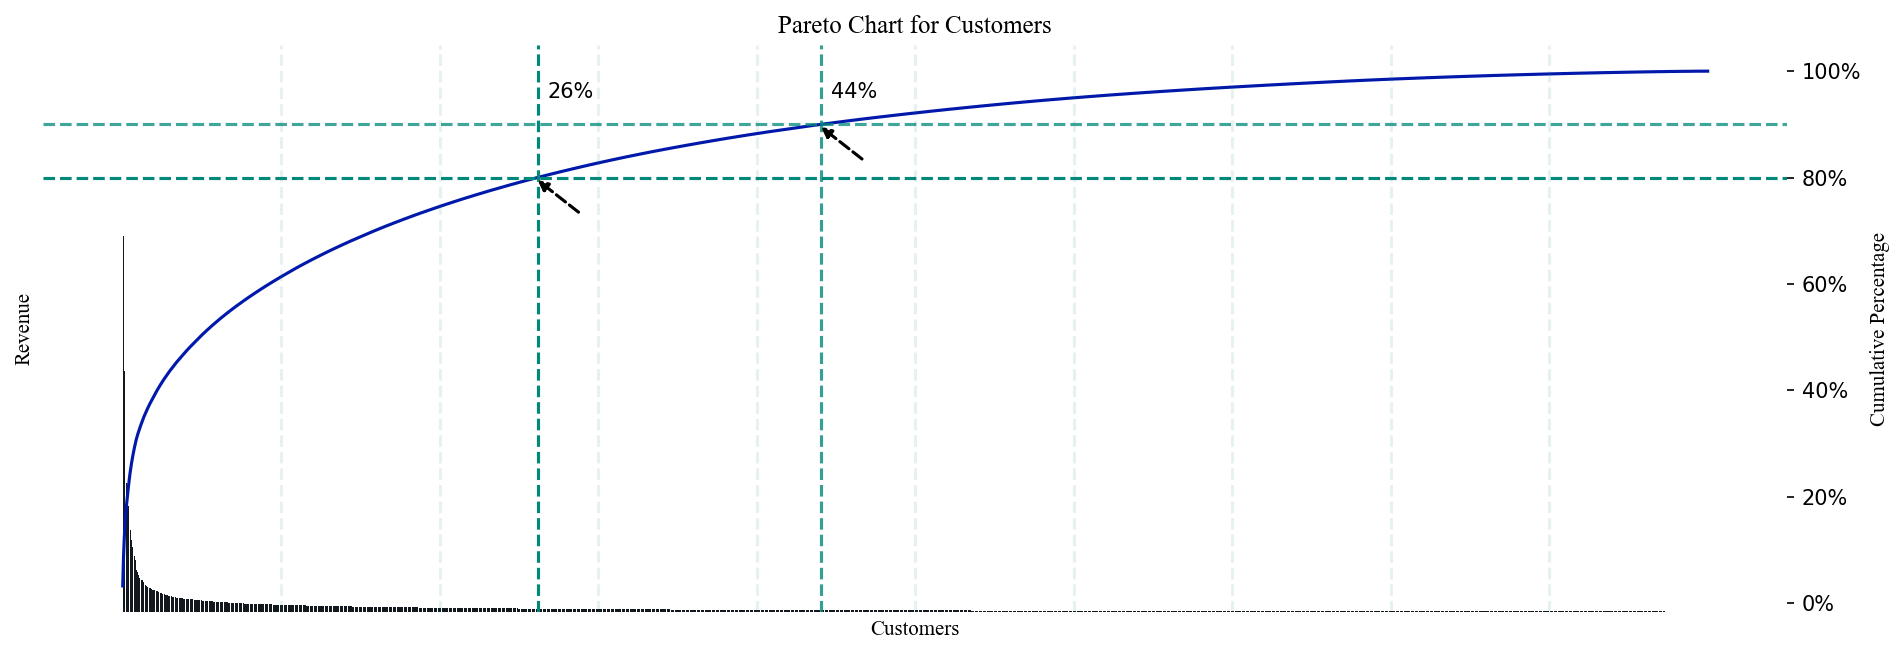

In [79]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

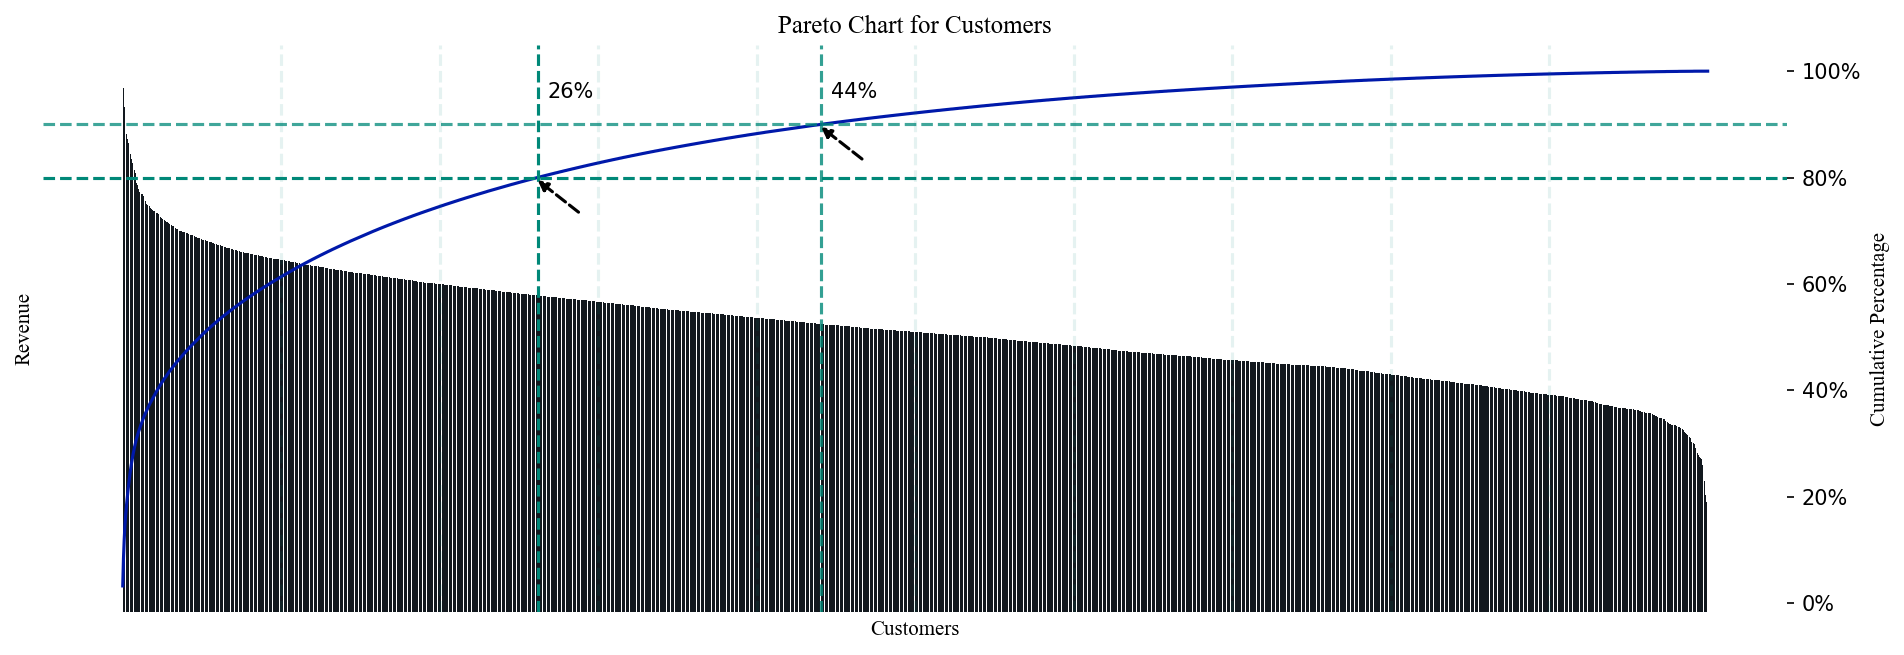

In [80]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

Well, lets interpret these two charts. Actually, we don't need to write a lot of things.

We can see that 80% of company's revenue comes from top 26% of customers.

Also, 90% of company's revenue comes from top 44% of customers.

In [81]:
# Creating a dataframe with the price by items stock code and it's respective cumulative percentage

item_price = prepare_pareto_data(pareto, "StockCode", "TotalPrice")

item_price.head(10)

TotalPrice  CumulativePercentage
StockCode                                  
23843       168469.60                  1.92
22423       142567.45                  3.55
85123A      100603.50                  4.70
85099B       85220.78                  5.67
23166        81416.73                  6.60
47566        68844.33                  7.39
84879        56580.34                  8.03
23084        51342.04                  8.62
22502        47366.20                  9.16
79321        46286.51                  9.69

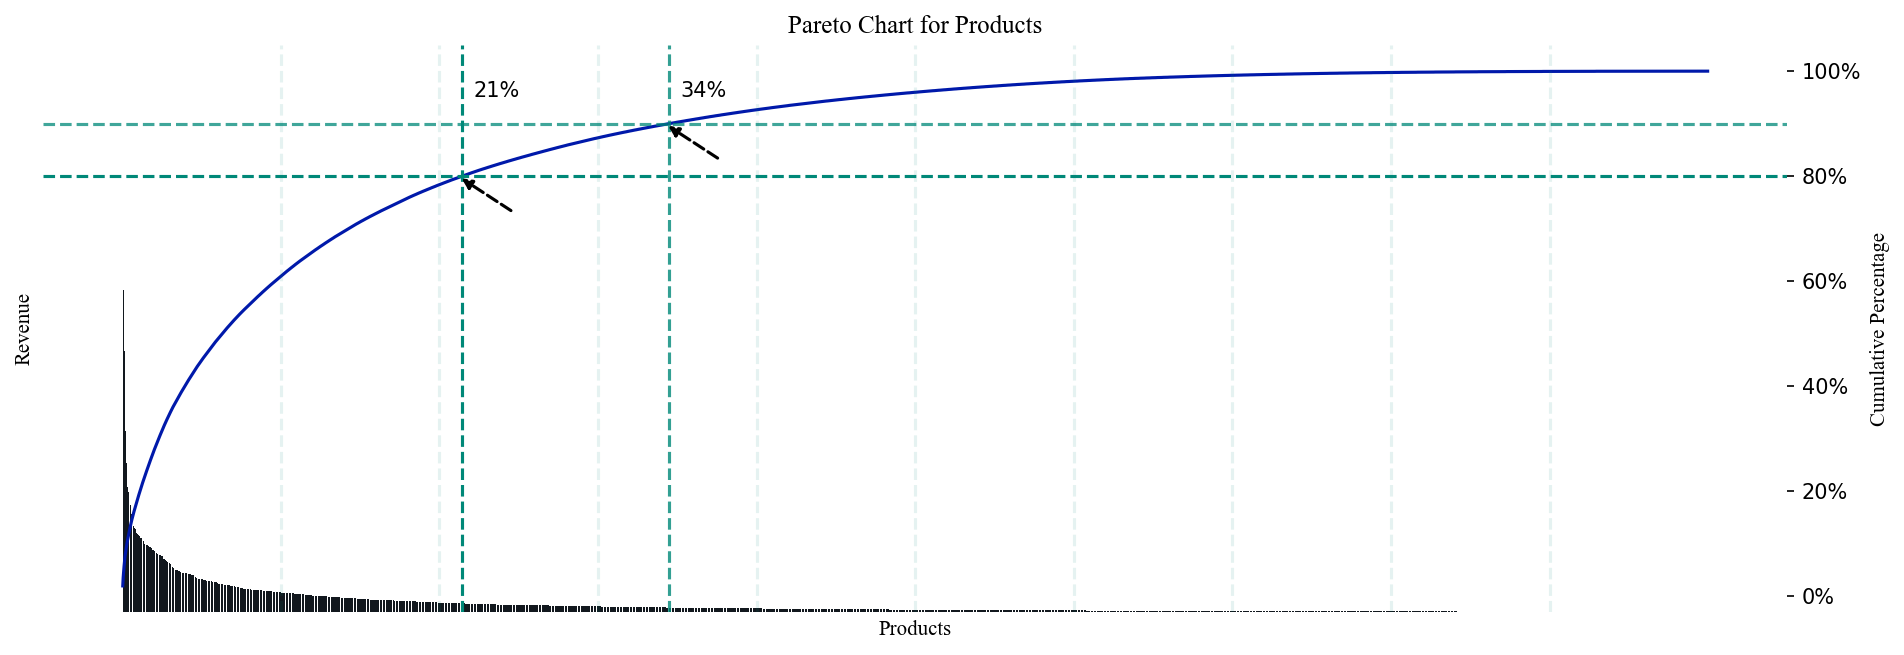

In [82]:
create_pareto_plot(item_price, "StockCode", "TotalPrice", log = False)

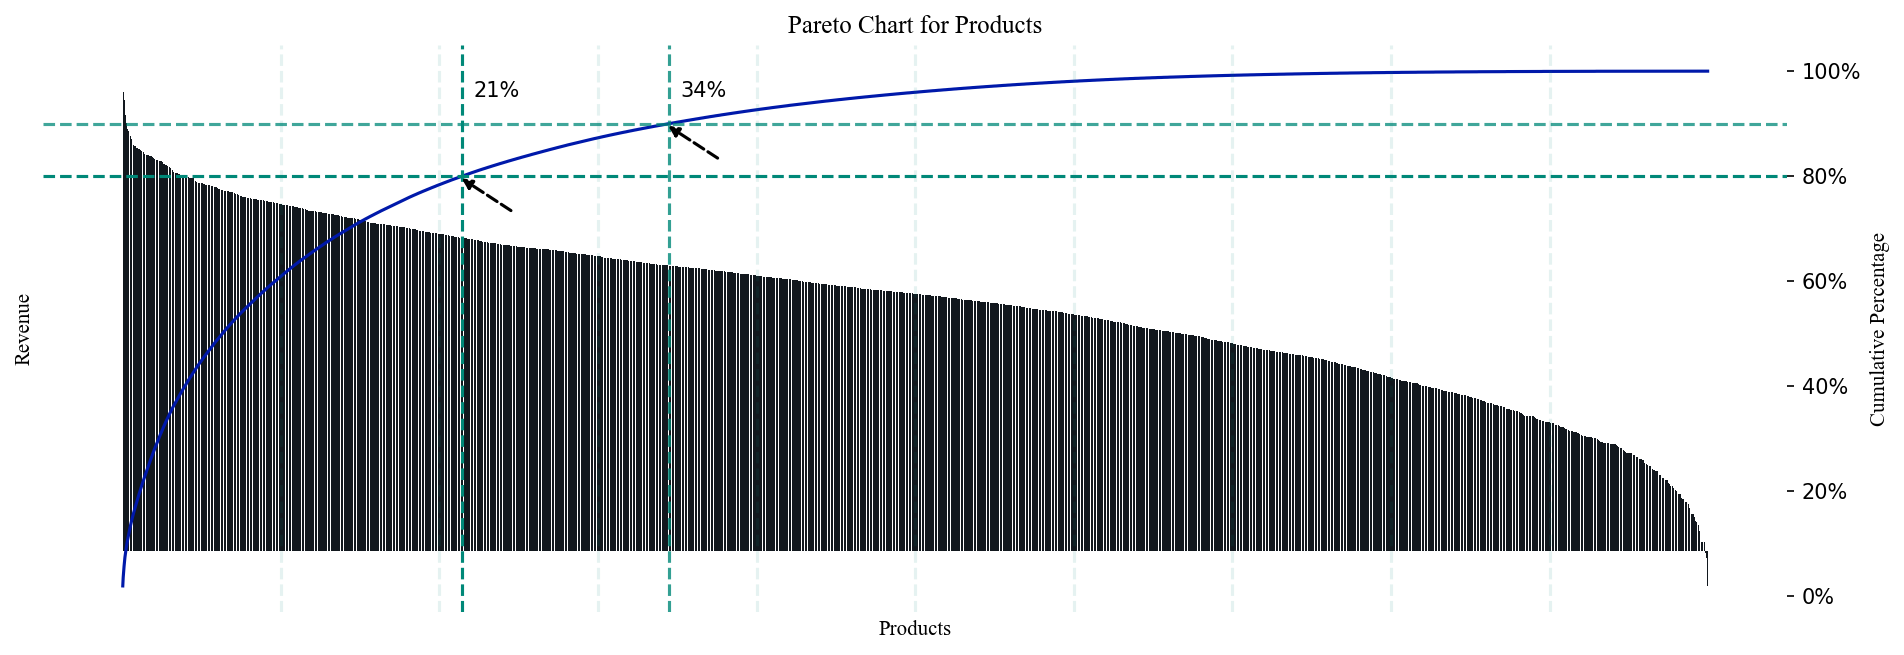

In [83]:
create_pareto_plot(item_price, "StockCode", "TotalPrice")

We can see that 80% of company's revenue comes from top 21% of products that have most revenue.

Also, 90% of company's revenue comes from 34% of products that have most revenue.

Maybe, if the company reduce by half its variety of items, revenue couldn't decrease significantly

<a class="anchor" id="basketanalysis">

## 5. Market Basket Analysis

</a>

In [84]:
market_basquet=gift_ic.copy()

In [85]:
#Code retrieved from: https://www.kaggle.com/code/blanik/kor-e-commerce-data-4-market-basket-analysis
# Getting the unique values for each variable
market_basquet.nunique().to_frame().transpose()

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
0      19776       3909         4014       374        18335        499   

   CustomerID  Country  
0        4334       38

In [86]:
market_basquet['StockCode'] = market_basquet['StockCode'].map(lambda x: x[:5])
market_basquet.nunique().to_frame().transpose()

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
0      19776       3286         4014       374        18335        499   

   CustomerID  Country  
0        4334       38

In [87]:
market_basquet = market_basquet.reset_index(drop=True)

In [88]:
market_basquet = market_basquet.groupby('InvoiceNo').filter(lambda x: len(x) >= 20)
market_basquet = market_basquet.groupby('StockCode').filter(lambda x: len(x) >= 20)
market_basquet.nunique().to_frame().transpose()

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
0       7898       2540         3095       255         7632        332   

   CustomerID  Country  
0        2512       35

In [89]:
cd_nm = market_basquet[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='first')
cd_nm = dict(zip(cd_nm['StockCode'], cd_nm['Description']))

In [90]:
basket = list(market_basquet.groupby('InvoiceNo')['StockCode'].agg(list))
basket[0]

['22139',
 '22411',
 '82567',
 '21672',
 '22774',
 '22771',
 '71270',
 '22262',
 '22637',
 '21934',
 '21169',
 '21166',
 '21175',
 '37444',
 '37444',
 '22086',
 '22083',
 '84971',
 '71270',
 '47580',
 '22261',
 '84832',
 '22644',
 '21533',
 '21557',
 '15056',
 '15056',
 '22646',
 '22176',
 '22438',
 '21731',
 '22778',
 '22719',
 '21523']

In [91]:
#Convert item lists into transaction data
te = TransactionEncoder()
basket = te.fit(basket).transform(basket)
basket = pd.DataFrame(basket, columns = te.columns_)
basket.head()

10002  10120  10125  10133  10135  11001  15034  15036  15039  15044  ...  \
0  False  False  False  False  False  False  False  False  False  False  ...   
1  False  False  False  False  False  False  False  False  False  False  ...   
2  False  False  False  False  False  False  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False  False  ...   
4  False  False  False  False  False  False  False  False  False  False  ...   

   90200  90201  90202  90205  90206  90208  90209  90210  90214  DCGSS  
0  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  False  False  

[5 rows x 2540 columns]

In [92]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 3% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)
frequent_itemsets.head()

support itemsets
0  0.047480  (15036)
1  0.069638  (15056)
2  0.035832  (16161)
3  0.032160  (16237)
4  0.035832  (20675)

In [93]:
# Generate the association rules - by lift
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_mlxtend.head()

antecedents consequents  antecedent support  consequent support   support  \
0     (15056)     (85099)            0.069638            0.236516  0.035832   
1     (85099)     (15056)            0.236516            0.069638  0.035832   
2     (20712)     (20711)            0.091416            0.056090  0.033679   
3     (20711)     (20712)            0.056090            0.091416  0.033679   
4     (21931)     (20711)            0.123449            0.056090  0.034312   

   confidence      lift  leverage  conviction  
0    0.514545  2.175525  0.019361    1.572721  
1    0.151499  2.175525  0.019361    1.096477  
2    0.368421  6.568374  0.028552    1.494524  
3    0.600451  6.568374  0.028552    2.274028  
4    0.277949  4.955393  0.027388    1.307262

In [94]:
# Getting the descripton for each stock code
rules_mlxtend['antecedents'] = rules_mlxtend['antecedents'].map(lambda x: [cd_nm[el] for el in x])
rules_mlxtend['consequents'] = rules_mlxtend['consequents'].map(lambda x: [cd_nm[el] for el in x])
rules_mlxtend.head()

antecedents                       consequents  \
0         [EDWARDIAN PARASOL BLACK]  [JUMBO  BAG BAROQUE BLACK WHITE]   
1  [JUMBO  BAG BAROQUE BLACK WHITE]         [EDWARDIAN PARASOL BLACK]   
2      [JUMBO BAG WOODLAND ANIMALS]                 [JUMBO BAG TOYS ]   
3                 [JUMBO BAG TOYS ]      [JUMBO BAG WOODLAND ANIMALS]   
4          [JUMBO STORAGE BAG SUKI]                 [JUMBO BAG TOYS ]   

   antecedent support  consequent support   support  confidence      lift  \
0            0.069638            0.236516  0.035832    0.514545  2.175525   
1            0.236516            0.069638  0.035832    0.151499  2.175525   
2            0.091416            0.056090  0.033679    0.368421  6.568374   
3            0.056090            0.091416  0.033679    0.600451  6.568374   
4            0.123449            0.056090  0.034312    0.277949  4.955393   

   leverage  conviction  
0  0.019361    1.572721  
1  0.019361    1.096477  
2  0.028552    1.494524  
3  0.028552    2.274028  
4  0.027388    1.307262

In [95]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.head()

antecedents consequents  antecedent support  consequent support   support  \
0     (15056)     (85099)            0.069638            0.236516  0.035832   
1     (20711)     (20712)            0.056090            0.091416  0.033679   
2     (20711)     (21931)            0.056090            0.123449  0.034312   
3     (20711)     (22386)            0.056090            0.113446  0.031654   
4     (20711)     (22411)            0.056090            0.119524  0.031400   

   confidence      lift  leverage  conviction  
0    0.514545  2.175525  0.019361    1.572721  
1    0.600451  6.568374  0.028552    2.274028  
2    0.611738  4.955393  0.027388    2.257629  
3    0.564334  4.974454  0.025290    2.034939  
4    0.559819  4.683743  0.024696    2.000261

In [96]:
# Getting the descripton for each stock code
rulesConfidence['antecedents'] = rulesConfidence['antecedents'].map(lambda x: [cd_nm[el] for el in x])
rulesConfidence['consequents'] = rulesConfidence['consequents'].map(lambda x: [cd_nm[el] for el in x])
rulesConfidence.head(10)

antecedents                          consequents  \
0     [EDWARDIAN PARASOL BLACK]     [JUMBO  BAG BAROQUE BLACK WHITE]   
1             [JUMBO BAG TOYS ]         [JUMBO BAG WOODLAND ANIMALS]   
2             [JUMBO BAG TOYS ]             [JUMBO STORAGE BAG SUKI]   
3             [JUMBO BAG TOYS ]            [JUMBO BAG PINK POLKADOT]   
4             [JUMBO BAG TOYS ]  [JUMBO SHOPPER VINTAGE RED PAISLEY]   
5             [JUMBO BAG TOYS ]     [JUMBO  BAG BAROQUE BLACK WHITE]   
6  [JUMBO BAG WOODLAND ANIMALS]             [JUMBO STORAGE BAG SUKI]   
7  [JUMBO BAG WOODLAND ANIMALS]            [JUMBO BAG PINK POLKADOT]   
8  [JUMBO BAG WOODLAND ANIMALS]  [JUMBO SHOPPER VINTAGE RED PAISLEY]   
9  [JUMBO BAG WOODLAND ANIMALS]     [JUMBO  BAG BAROQUE BLACK WHITE]   

   antecedent support  consequent support   support  confidence      lift  \
0            0.069638            0.236516  0.035832    0.514545  2.175525   
1            0.056090            0.091416  0.033679    0.600451  6.568374   
2            0.056090            0.123449  0.034312    0.611738  4.955393   
3            0.056090            0.113446  0.031654    0.564334  4.974454   
4            0.056090            0.119524  0.031400    0.559819  4.683743   
5            0.056090            0.236516  0.044315    0.790068  3.340447   
6            0.091416            0.123449  0.052418    0.573407  4.644892   
7            0.091416            0.113446  0.048367    0.529086  4.663750   
8            0.091416            0.119524  0.045961    0.502770  4.206439   
9            0.091416            0.236516  0.069764    0.763158  3.226671   

   leverage  conviction  
0  0.019361    1.572721  
1  0.028552    2.274028  
2  0.027388    2.257629  
3  0.025290    2.034939  
4  0.024696    2.000261  
5  0.031049    3.636813  
6  0.041133    2.054772  
7  0.037996    1.882623  
8  0.035035    1.770762  
9  0.048143    3.223601

In [97]:
# High Confidence and high Lift - complementary products
rules_mlxtend[ (rules_mlxtend['lift'] >= 4) & (rules_mlxtend['confidence'] >= 0.8) ].head(10)

antecedents  \
253                       [SET/6 RED SPOTTY PAPER CUPS]   
565                [WOODEN TREE CHRISTMAS SCANDINAVIAN]   
592                    [PINK REGENCY TEACUP AND SAUCER]   
606                    [PINK REGENCY TEACUP AND SAUCER]   
828   [STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...   
852   [CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...   
870   [STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...   
876   [CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...   
894   [CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...   
1240  [PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   

                               consequents  antecedent support  \
253        [SET/6 RED SPOTTY PAPER PLATES]            0.041403   
565   [WOODEN STAR CHRISTMAS SCANDINAVIAN]            0.036085   
592      [GREEN REGENCY TEACUP AND SAUCER]            0.069258   
606     [ROSES REGENCY TEACUP AND SAUCER ]            0.069258   
828          [RED RETROSPOT CHARLOTTE BAG]            0.047354   
852          [RED RETROSPOT CHARLOTTE BAG]            0.046214   
870          [RED RETROSPOT CHARLOTTE BAG]            0.047227   
876          [RED RETROSPOT CHARLOTTE BAG]            0.042796   
894          [RED RETROSPOT CHARLOTTE BAG]            0.046974   
1240     [GREEN REGENCY TEACUP AND SAUCER]            0.036718   

      consequent support   support  confidence       lift  leverage  \
253             0.052545  0.034186    0.825688  15.713938  0.032010   
565             0.050646  0.030134    0.835088  16.488807  0.028307   
592             0.094961  0.059129    0.853748   8.990533  0.052552   
606             0.098253  0.056090    0.809872   8.242744  0.049285   
828             0.107116  0.038744    0.818182   7.638298  0.033672   
852             0.107116  0.037984    0.821918   7.673176  0.033034   
870             0.107116  0.038491    0.815013   7.608719  0.033432   
876             0.107116  0.037098    0.866864   8.092779  0.032514   
894             0.107116  0.038111    0.811321   7.574245  0.033079   
1240            0.094961  0.033173    0.903448   9.513913  0.029686   

      conviction  
253     5.435400  
565     5.756723  
592     6.188206  
606     4.742844  
828     4.910864  
852     5.013889  
870     4.826751  
876     6.706553  
894     4.732287  
1240    9.373621

In [98]:
# Substitute products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

antecedents consequents  antecedent support  consequent support   support  \
539     (85099)     (22423)            0.236516            0.159407  0.043682   
538     (22423)     (85099)            0.159407            0.236516  0.043682   
540     (85123)     (22423)            0.189162            0.159407  0.038238   
541     (22423)     (85123)            0.159407            0.189162  0.038238   
224     (85123)     (20727)            0.189162            0.132059  0.031907   
225     (20727)     (85123)            0.132059            0.189162  0.031907   
295     (21212)     (85123)            0.134591            0.189162  0.033046   
294     (85123)     (21212)            0.189162            0.134591  0.033046   
481     (22383)     (85123)            0.130539            0.189162  0.032287   
480     (85123)     (22383)            0.189162            0.130539  0.032287   

     confidence      lift  leverage  conviction  
539    0.184690  1.158600  0.005980    1.031009  
538    0.274027  1.158600  0.005980    1.051671  
540    0.202142  1.268083  0.008084    1.053561  
541    0.239873  1.268083  0.008084    1.066714  
224    0.168675  1.277270  0.006926    1.044045  
225    0.241611  1.277270  0.006926    1.069158  
295    0.245532  1.297997  0.007587    1.074714  
294    0.174699  1.297997  0.007587    1.048598  
481    0.247333  1.307519  0.007594    1.077286  
480    0.170683  1.307519  0.007594    1.048405

In [99]:
# Getting the descripton for each stock code
rulesLift2['antecedents'] = rulesLift2['antecedents'].map(lambda x: [cd_nm[el] for el in x])
rulesLift2['consequents'] = rulesLift2['consequents'].map(lambda x: [cd_nm[el] for el in x])
rulesLift2.head(10)

antecedents  \
539      [JUMBO  BAG BAROQUE BLACK WHITE]   
538            [REGENCY CAKESTAND 3 TIER]   
540  [WHITE HANGING HEART T-LIGHT HOLDER]   
541            [REGENCY CAKESTAND 3 TIER]   
224  [WHITE HANGING HEART T-LIGHT HOLDER]   
225             [LUNCH BAG  BLACK SKULL.]   
295     [PACK OF 72 RETROSPOT CAKE CASES]   
294  [WHITE HANGING HEART T-LIGHT HOLDER]   
481             [LUNCH BAG SUKI  DESIGN ]   
480  [WHITE HANGING HEART T-LIGHT HOLDER]   

                              consequents  antecedent support  \
539            [REGENCY CAKESTAND 3 TIER]            0.236516   
538      [JUMBO  BAG BAROQUE BLACK WHITE]            0.159407   
540            [REGENCY CAKESTAND 3 TIER]            0.189162   
541  [WHITE HANGING HEART T-LIGHT HOLDER]            0.159407   
224             [LUNCH BAG  BLACK SKULL.]            0.189162   
225  [WHITE HANGING HEART T-LIGHT HOLDER]            0.132059   
295  [WHITE HANGING HEART T-LIGHT HOLDER]            0.134591   
294     [PACK OF 72 RETROSPOT CAKE CASES]            0.189162   
481  [WHITE HANGING HEART T-LIGHT HOLDER]            0.130539   
480             [LUNCH BAG SUKI  DESIGN ]            0.189162   

     consequent support   support  confidence      lift  leverage  conviction  
539            0.159407  0.043682    0.184690  1.158600  0.005980    1.031009  
538            0.236516  0.043682    0.274027  1.158600  0.005980    1.051671  
540            0.159407  0.038238    0.202142  1.268083  0.008084    1.053561  
541            0.189162  0.038238    0.239873  1.268083  0.008084    1.066714  
224            0.132059  0.031907    0.168675  1.277270  0.006926    1.044045  
225            0.189162  0.031907    0.241611  1.277270  0.006926    1.069158  
295            0.189162  0.033046    0.245532  1.297997  0.007587    1.074714  
294            0.134591  0.033046    0.174699  1.297997  0.007587    1.048598  
481            0.189162  0.032287    0.247333  1.307519  0.007594    1.077286  
480            0.130539  0.032287    0.170683  1.307519  0.007594    1.048405

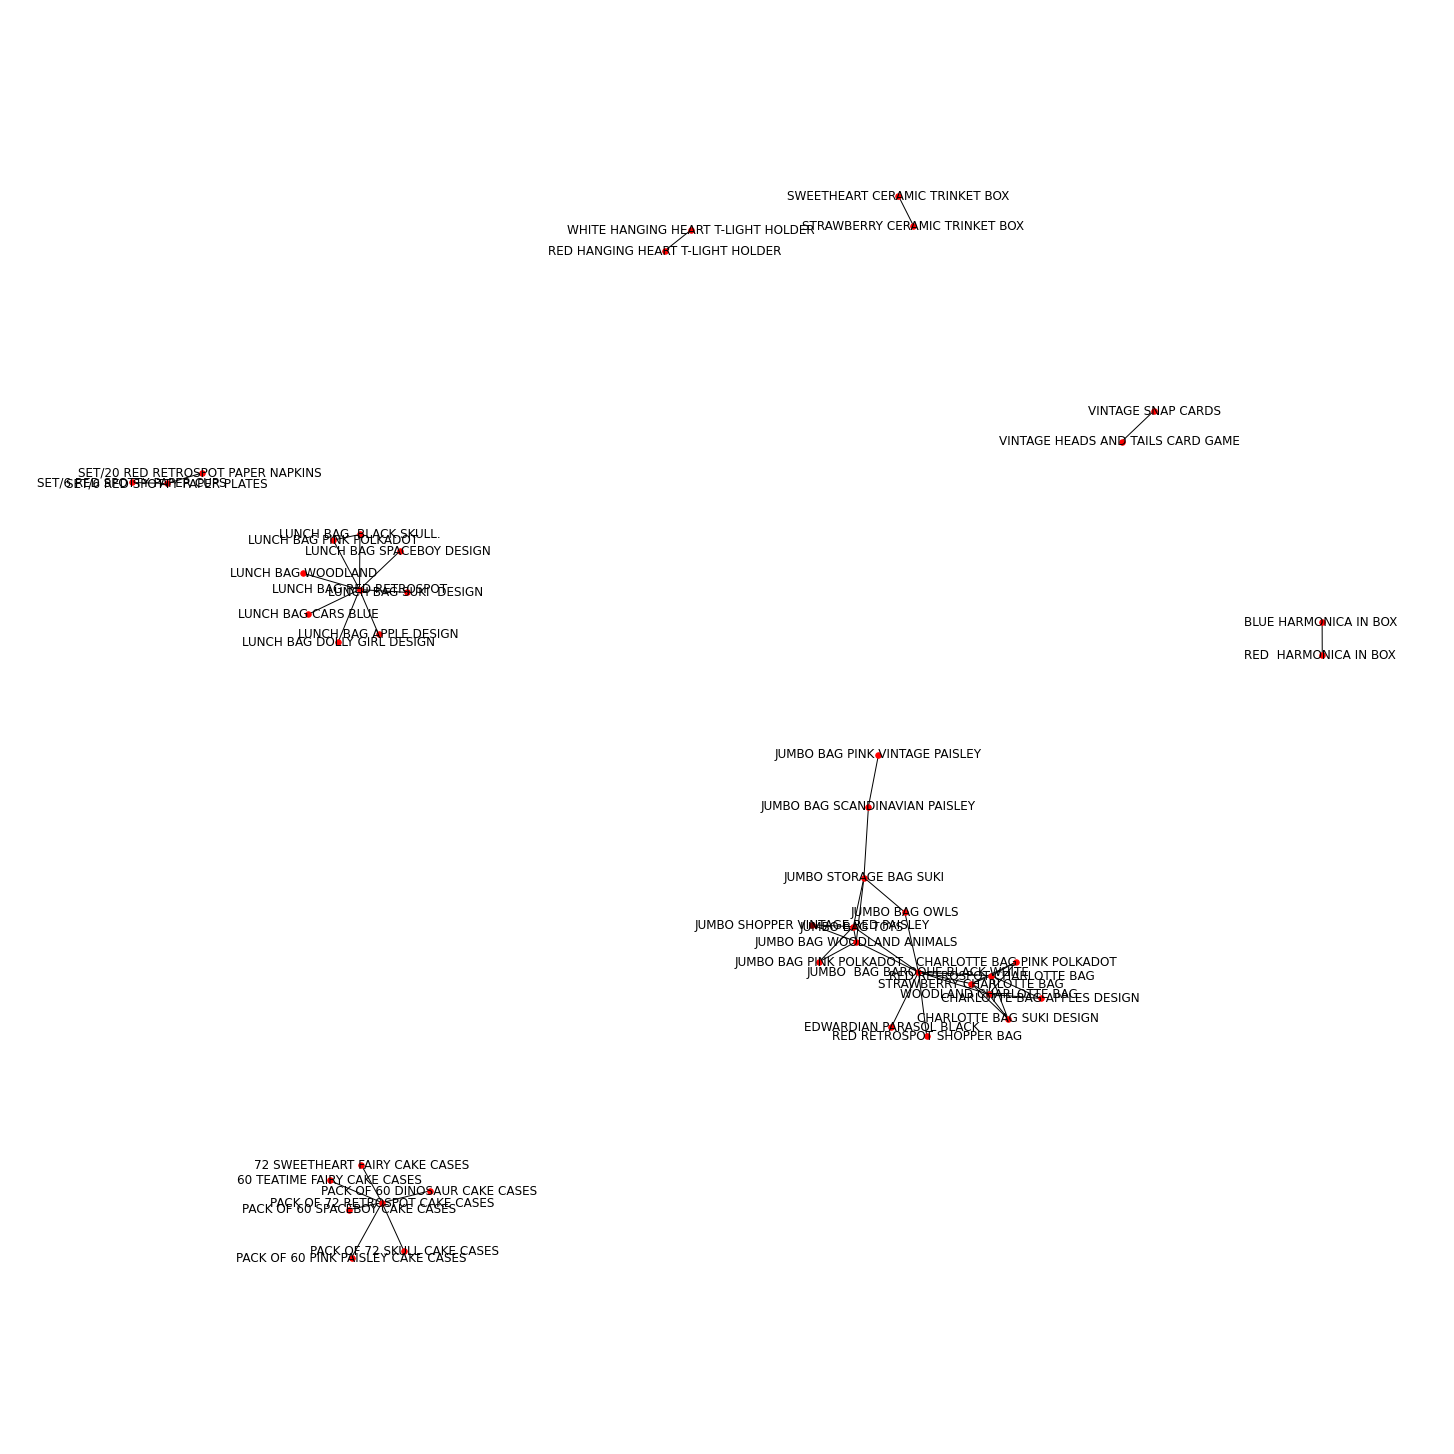

In [100]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()

<hr>
<a class="anchor" id="cold">
    
# 6. Cold Start Problem
    
</a>

In [101]:
# cold start - suggesting the most popular product of the country and season to new customers

gift_eng = gift_eng[~gift_eng['CustomerID'].isna()]

gift_freq = gift_eng.copy()

def cold_start(season, country):
    
    df_topproducts = gift_freq[(gift_freq['Country'] == country) & (gift_freq['Season'] == season)]
    
    
    top_products = list(df_topproducts.groupby('StockCode')['StockCode'].count().sort_values(ascending=False).head(3).index)
    
    return list(gift_freq['Description'][gift_freq['StockCode'].isin(top_products)].unique())

cold_start('Spring', 'Portugal')

['SET/20 RED RETROSPOT PAPER NAPKINS ',
 'RED SPOTTY BISCUIT TIN',
 'SET 3 PAPER VINTAGE CHICK PAPER EGG']

<hr>
<a class="anchor" id="recommendation">
    
# 7. Recommendation System
    
</a>

### -  Reduce Sparsity

In [102]:
gift_red = gift_eng.copy()

In [103]:
## eliminates the customers that have a frequency of fewer than 4 transactions and less than 4 item frequency

def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [104]:
# get limited dataset
gift_limited = threshold_ratings(gift_red, 4, 4)

Raw dataset info 
-----------------
Number of users: 4334
Number of items: 3659
Sparsity: 2.466%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 4152
Number of items: 3249
Sparsity: 2.890%


<hr>
<a class="anchor" id="ALS">
    
## 7.1. ALS (Alternative Least Squares)
    
</a>

In [126]:
gift_als = gift_limited.copy()

###  - Train-test Split

In [127]:
# Train-test split
start_train = gift_als['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
gift_limited = gift_als.loc[(gift_als['InvoiceDate'] > start_train) & (gift_als['InvoiceDate'] <= end_test)]

# Create train_split flag
gift_als['train_split'] = (gift_als['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(gift_als['train_split'].mean()))

Proportion of train events: 0.71


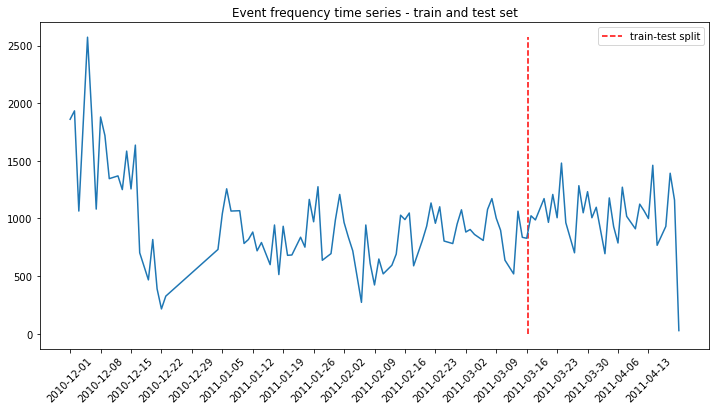

In [128]:
# Visualize train and test set
data = pd.DatetimeIndex(gift_als['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

In [129]:
# creating dataframe with only 'CustomerID', 'StockCode', 'Description', 'train_split' variables
grouped_df = gift_als[['CustomerID', 'StockCode', 'Description', 'train_split']].groupby(['CustomerID', 'StockCode', 'Description']).sum().reset_index()
grouped_df.head(5)

CustomerID StockCode                          Description  train_split
0       12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)            0
1       12347     20665                 RED RETROSPOT PURSE             0
2       12347     20719               WOODLAND CHARLOTTE BAG            1
3       12347     20780            BLACK EAR MUFF HEADPHONES            1
4       12347     20782       CAMOUFLAGE EAR MUFF HEADPHONES            1

###  - Implicit Feedback

In [130]:
# array of customers (unique)
unique_customers = grouped_df.CustomerID.unique()

# dictionary of customer ids
customer_ids = dict(zip(unique_customers, np.arange(unique_customers.shape[0], dtype=np.int32)))

# array of items (unique)
unique_items = grouped_df.StockCode.unique()

# dictionary of item ids
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

# create column with reseted ids for the originals customers ids
grouped_df['customer_id'] = grouped_df.CustomerID.apply(lambda i: customer_ids[i])

# create column with reseted ids for the originals item ids
grouped_df['item_id'] = grouped_df.StockCode.apply(lambda i: item_ids[i])

In [131]:
grouped_df.head()

CustomerID StockCode                          Description  train_split  \
0       12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)            0   
1       12347     20665                 RED RETROSPOT PURSE             0   
2       12347     20719               WOODLAND CHARLOTTE BAG            1   
3       12347     20780            BLACK EAR MUFF HEADPHONES            1   
4       12347     20782       CAMOUFLAGE EAR MUFF HEADPHONES            1   

   customer_id  item_id  
0            0        0  
1            0        1  
2            0        2  
3            0        3  
4            0        4

In [132]:
# create a sparse matrix of all the item/user/counts triples for the train set and test set
item_customer_train = sparse.csr_matrix((grouped_df['train_split'].astype(bool), (grouped_df['item_id'], grouped_df['customer_id'])))
item_customer_test = sparse.csr_matrix((~grouped_df['train_split'].astype(bool), (grouped_df['item_id'], grouped_df['customer_id'])))

In [133]:
# initializing a model
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (item_customer_train * alpha).astype('double')

# train the model on a sparse matrix of item/user/confidence weights
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

### Finding the Similar Items

In [134]:
def similar_item(stock_id):
    description=[]
    score=[]
    d_stock = dict(enumerate(grouped_df['StockCode'].astype("category").cat.categories))
    stock_id = [k for k, v in d_stock.items() if v == stock_id][0]
    for i in range(10):
        description.append(grouped_df['Description'][grouped_df['item_id']==  model.similar_items(stock_id)[0][i]].unique())
        score.append( model.similar_items(stock_id)[1][i])
    return pd.DataFrame(np.column_stack([description, score]), columns=['description', 'score'])

similar_item('10002')

description     score
0  SMALL FOLDING SCISSOR(POINTED EDGE)       1.0
1                   SWEETIES  STICKERS  0.664458
2                 RED POLKADOT BEAKER   0.637743
3   JARDIN ETCHED GLASS SMALL BELL JAR  0.625492
4    PACK OF 12 RED RETROSPOT TISSUES   0.616633
5              BLACK HEART CARD HOLDER  0.610628
6  MAGIC DRAWING SLATE CIRCUS PARADE    0.609024
7         COLOURING PENCILS BROWN TUBE  0.607018
8               FELT FARM ANIMAL SHEEP  0.606553
9           DOORMAT MULTICOLOUR STRIPE  0.594679

### Recommend Items to Customers

In [135]:
# find related items
# the related items have the largest inner product with the item vector
def recommend(customer_id):
    description=[]
    score=[]
    d_customer = dict(enumerate(grouped_df['CustomerID'].astype("category").cat.categories))
    user_id = [k for k, v in d_customer.items() if v == customer_id][0]
    for i in range(10):
        description.append(grouped_df['Description'][grouped_df['item_id']==  model.recommend(user_id,item_customer_train,filter_already_liked_items=False)[0][i]].unique())
        score.append( model.recommend(user_id, item_customer_train, filter_already_liked_items=False)[1][i])
    return pd.DataFrame(np.column_stack([description, score]), columns=['description', 'score'])


# choose the customer to recommend
recommend(12577)

description     score
0              MA CAMPAGNE CUTLERY BOX   0.84937
1       PURPLE BOUDICCA LARGE BRACELET  0.710817
2           WOODEN SKITTLES GARDEN SET  0.696603
3       CHRISTMAS CRAFT LITTLE FRIENDS  0.672997
4  PAINTED METAL HEART WITH HOLLY BELL  0.653262
5           PARTY CONES CANDY ASSORTED  0.598479
6  CHARLIE & LOLA WASTEPAPER BIN FLORA  0.584597
7          COLOURFUL FLOWER FRUIT BOWL  0.562474
8              TEATIME PEN CASE & PENS  0.533543
9          GREY HEART HOT WATER BOTTLE  0.531071

In [148]:
# evaluate the model
ranking_metrics_at_k(model, item_customer_train, item_customer_test,K=10,show_progress=True,num_threads=0)

  0%|          | 0/2687 [00:00<?, ?it/s]

{'precision': 0.0, 'map': 0.0, 'ndcg': 0.0, 'auc': 0.49778448075836057}

<hr>
<a class="anchor" id="aals">
    
## 7.2. Approximate Alternative Least Squares
    
</a>

In [137]:
gift_logistic = gift_limited.copy()

###  - Train-test Split

In [138]:
# Train-test split
start_train = gift_logistic['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
gift_logistic = gift_logistic.loc[(gift_logistic['InvoiceDate'] > start_train) & (gift_logistic['InvoiceDate'] <= end_test)]

# Create train_split flag
gift_logistic['train_split'] = (gift_logistic['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(gift_logistic['train_split'].mean()))

Proportion of train events: 0.71


In [139]:
# creating dataframe with only 'CustomerID', 'StockCode', 'Description', 'train_split' variables
grouped_df = gift_logistic[['CustomerID', 'StockCode', 'Description', 'train_split']].groupby(['CustomerID', 'StockCode', 'Description']).sum().reset_index()
grouped_df.head(5)

CustomerID StockCode                          Description  train_split
0       12347     16008  SMALL FOLDING SCISSOR(POINTED EDGE)            0
1       12347     20665                 RED RETROSPOT PURSE             0
2       12347     20719               WOODLAND CHARLOTTE BAG            1
3       12347     20780            BLACK EAR MUFF HEADPHONES            1
4       12347     20782       CAMOUFLAGE EAR MUFF HEADPHONES            1

###  - Implicit Feedback

In [140]:
# array of customers (unique)
unique_customers = grouped_df.CustomerID.unique()

# dictionary of customer ids
customer_ids = dict(zip(unique_customers, np.arange(unique_customers.shape[0], dtype=np.int32)))

# array of items (unique)
unique_items = grouped_df.StockCode.unique()

# dictionary of item ids
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

# create column with reseted ids for the originals customers ids
grouped_df['customer_id'] = grouped_df.CustomerID.apply(lambda i: customer_ids[i])

# create column with reseted ids for the originals item ids
grouped_df['item_id'] = grouped_df.StockCode.apply(lambda i: item_ids[i])

In [141]:
# create a sparse matrix of all the item/user/counts triples for the train set and test set
item_customer_train = sparse.csr_matrix((grouped_df['train_split'].astype(bool), (grouped_df['item_id'], grouped_df['customer_id'])))
item_customer_test = sparse.csr_matrix((~grouped_df['train_split'].astype(bool), (grouped_df['item_id'], grouped_df['customer_id'])))

In [142]:
# initializing a model
model1 = implicit.approximate_als.NMSLibAlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (item_customer_train * alpha).astype('double')

# train the model on a sparse matrix of item/user/confidence weights
model1.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

### Finding the Similar Items

In [143]:
def similar_item(stock_id):
    description=[]
    score=[]
    d_stock = dict(enumerate(grouped_df['StockCode'].astype("category").cat.categories))
    stock_id = [k for k, v in d_stock.items() if v == stock_id][0]
    for i in range(10):
        description.append(grouped_df['Description'][grouped_df['item_id']==  model1.similar_items(stock_id)[0][i]].unique())
        score.append( model1.similar_items(stock_id)[1][i])
    return pd.DataFrame(np.column_stack([description, score]), columns=['description', 'score'])

similar_item('10002')

description     score
0  SMALL FOLDING SCISSOR(POINTED EDGE)       1.0
1        CHERRY BLOSSOM PASSPORT COVER  0.680141
2                   SWEETIES  STICKERS   0.64741
3                   SOAP DISH BROCANTE  0.597872
4      SET OF 4 ROSE BOTANICAL CANDLES  0.585216
5  CHARLIE & LOLA WASTEPAPER BIN FLORA  0.578764
6           HEART FILIGREE DOVE  SMALL  0.564668
7     PINK POLKADOT CHILDRENS UMBRELLA  0.557725
8          SPOTS ON RED BOOKCOVER TAPE  0.548198
9          POTTING SHED SEED ENVELOPES  0.544144

### Recommend Items to Customers

In [144]:
# find related items
# the related items have the largest inner product with the item vector
def recommend(customer_id):
    description=[]
    score=[]
    d_customer = dict(enumerate(grouped_df['CustomerID'].astype("category").cat.categories))
    user_id = [k for k, v in d_customer.items() if v == customer_id][0]
    for i in range(10):
        description.append(grouped_df['Description'][grouped_df['item_id']==  model1.recommend(user_id,item_customer_train,filter_already_liked_items=False)[0][i]].unique())
        score.append( model1.recommend(user_id, item_customer_train, filter_already_liked_items=False)[1][i])
    return pd.DataFrame(np.column_stack([description, score]), columns=['description', 'score'])

recommend(12577)

description     score
0              MA CAMPAGNE CUTLERY BOX  0.806568
1  PAINTED METAL HEART WITH HOLLY BELL  0.713073
2       CHRISTMAS CRAFT LITTLE FRIENDS  0.645994
3       PURPLE BOUDICCA LARGE BRACELET  0.618681
4           WOODEN SKITTLES GARDEN SET  0.608076
5           PARTY CONES CANDY ASSORTED  0.601579
6          GREY HEART HOT WATER BOTTLE  0.570372
7        SMALL GLASS SUNDAE DISH CLEAR  0.552144
8        BLACK MEDIUM GLASS CAKE STAND  0.542992
9  CHARLIE & LOLA WASTEPAPER BIN FLORA  0.527356

In [147]:
# evaluate the model
ranking_metrics_at_k(model1, item_customer_train, item_customer_test,K=10,show_progress=True,num_threads=0)

  0%|          | 0/2687 [00:00<?, ?it/s]

{'precision': 0.0, 'map': 0.0, 'ndcg': 0.0, 'auc': 0.49778448075836057}

<hr>
<a class="anchor" id="rules">
    
## 7.3. Association Rules modelling : Fp growth algorithm
    
</a>

In [178]:
gift_ass = gift_eng.copy()

In [179]:
liste= gift_ass['StockCode'].unique() 
stock_to_del=[]
for el in liste:
    if el[0] not in ['1','2','3', '4', '5', '6', '7', '8', '9', '10']: # products corresponding to gifts. 
        stock_to_del.append(el)

gift_ass=gift_ass[gift_ass['StockCode'].map(lambda x: x not in stock_to_del)] # delete these products

basket = gift_ass.groupby(['InvoiceNo','CustomerID']).agg({'StockCode': lambda s: list(set(s))}) # grouping product from the same invoice. 

print('Dimension of the new grouped dataset : ', basket.shape)
print('----------')
basket.head()

Dimension of the new grouped dataset :  (18402, 1)
----------


StockCode
InvoiceNo CustomerID                                                   
536365    17850       [84029E, 71053, 84029G, 84406B, 22752, 21730, ...
536366    17850                                          [22632, 22633]
536367    13047       [22623, 21755, 84879, 21777, 22749, 22748, 223...
536368    13047                            [22960, 22912, 22913, 22914]
536369    13047                                                 [21756]

In [180]:
# the first step of FP-growth is to calculate item frequencies and identify frequent items

#The second step of FP-growth uses a suffix tree (FP-tree) structure to encode transactions 
#without generating candidate sets explicitly, which are usually expensive to generate. 

#After the second step, the frequent itemsets can be extracted from the FP-tree and the model
#returns a set of product association rules

a=time.time()
freqItemSet, rules = fpgrowth(basket['StockCode'].values, minSupRatio=0.005, minConf=0.3)
b=time.time()
print('time to execute in seconds : ',b-a, ' s.')
print('Number of rules generated : ', len(rules))

association=pd.DataFrame(rules,columns =['basket','next_product','proba']) 
association=association.sort_values(by='proba',ascending=False)
print('Dimensions of the association table are : ', association.shape)
association.head()

time to execute in seconds :  1016.6454107761383  s.
Number of rules generated :  8298
Dimensions of the association table are :  (8298, 3)


basket next_product     proba
274  {22917, 22916, 22919, 22921, 22920}      {22918}  0.992481
497         {22917, 22921, 22916, 22919}      {22918}  0.985915
380         {22917, 22921, 22918, 22920}      {22916}  0.985612
382         {22917, 22921, 22916, 22920}      {22918}  0.985612
169         {22917, 22921, 22920, 22919}      {22918}  0.985294

In [181]:
#From the basket of a user, returns the product to recommend if it was not found 
#in the list of associations of the table associated with the FP Growth model. 

def compute_next_best_product(basket_el):
    
    for k in basket_el: # for each element in the consumer basket
            k={k}
            if len(association[association['basket']==k].values) !=0: # if we find a corresponding association in the fp growth table
                next_pdt=list(association[association['basket']==k]['next_product'].values[0])[0] # we take the consequent product
                if next_pdt not in basket_el : # We verify that the customer has not previously purchased the product
                    proba=association[association['basket']==k]['proba'].values[0] # Find the associated probability. 
                    return(next_pdt,proba)
    
    return(0,0) # return (0,0) if no product was found. 

In [182]:
#Main function that uses the one above. For each client in the dataset we look for a corresponding 
#association in the Fp Growth model table. If no association is found, we call the compute_next_best_product 
#function which searches for individual product associations.
#If no individual ssociations are found, the function returns (0,0).

def find_next_product(basket):
    n=basket.shape[0]
    list_next_pdt=[]
    list_proba=[]
    for i in range(n): # for each customer
        el=set(basket['StockCode'][i]) # customer's basket
        if len(association[association['basket']==el].values) !=0: # if we find a association in the fp growth table corresponding to all the customer's basket.
            next_pdt=list(association[association['basket']==el]['next_product'].values[0])[0] # We take the consequent product
            proba=association[association['basket']==el]['proba'].values[0] # Probability associated in the table
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)


        elif len(association[association['basket']==el].values) ==0: # If no antecedent to all the basket was found in the table
            next_pdt,proba= compute_next_best_product(basket['StockCode'][i]) # previous function
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)
            
    return(list_next_pdt, list_proba)

#### Computation for each customer

In [183]:
a=time.time()
list_next_pdt, list_proba= find_next_product(basket) 
b=time.time()
print(b-a)
basket['Recommended Product']=list_next_pdt # Set of recommended gifts
basket['Probability']=list_proba # Set of rprobabilities associated
basket.head()

452.5275990962982


StockCode  \
InvoiceNo CustomerID                                                      
536365    17850       [84029E, 71053, 84029G, 84406B, 22752, 21730, ...   
536366    17850                                          [22632, 22633]   
536367    13047       [22623, 21755, 84879, 21777, 22749, 22748, 223...   
536368    13047                            [22960, 22912, 22913, 22914]   
536369    13047                                                 [21756]   

                     Recommended Product  Probability  
InvoiceNo CustomerID                                   
536365    17850                    22111     0.314642  
536366    17850                    22865     0.560241  
536367    13047                    22750     0.593516  
536368    13047                    22961     0.350797  
536369    13047                    21754     0.578512

In [184]:
# Calculation of estimated prices from the recommendations made and display 
#of the final table with the association (customer, gift recommended)

basket=basket.rename(columns = {'StockCode': 'Customer basket'})
data_stock=gift_ass.drop_duplicates(subset ="StockCode", inplace = False)
prices=[]
description_list=[]
for i in range(basket.shape[0]):
    stockcode=basket['Recommended Product'][i]
    probability= basket['Probability'][i]
    if stockcode != 0:
        unitprice=data_stock[data_stock['StockCode']==stockcode]['UnitPrice'].values[0]
        description=data_stock[data_stock['StockCode']==stockcode]['Description'].values[0]
        estim_price=unitprice*probability
        prices.append(estim_price)
        description_list.append(description)
        
    else :
        prices.append(0)
        description_list.append('Null')

    

basket['Price estimation']=prices 
basket['Product description']=description_list 
basket = basket.reindex(columns=['Customer basket','Recommended Product','Product description','Probability','Price estimation'])
basket.head()

Customer basket  \
InvoiceNo CustomerID                                                      
536365    17850       [84029E, 71053, 84029G, 84406B, 22752, 21730, ...   
536366    17850                                          [22632, 22633]   
536367    13047       [22623, 21755, 84879, 21777, 22749, 22748, 223...   
536368    13047                            [22960, 22912, 22913, 22914]   
536369    13047                                                 [21756]   

                     Recommended Product           Product description  \
InvoiceNo CustomerID                                                     
536365    17850                    22111  SCOTTIE DOG HOT WATER BOTTLE   
536366    17850                    22865        HAND WARMER OWL DESIGN   
536367    13047                    22750  FELTCRAFT PRINCESS LOLA DOLL   
536368    13047                    22961        JAM MAKING SET PRINTED   
536369    13047                    21754      HOME BUILDING BLOCK WORD   

                      Probability  Price estimation  
InvoiceNo CustomerID                                 
536365    17850          0.314642          1.557477  
536366    17850          0.560241          1.036446  
536367    13047          0.593516          2.225686  
536368    13047          0.350797          0.508656  
536369    13047          0.578512          3.442149

In [185]:
print('On average, the recommendation system can predict in ',basket['Probability'].mean() *100,  '% of the cases the next product that the customer will buy.')

On average, the recommendation system can predict in  39.669236464418574 % of the cases the next product that the customer will buy.


In [186]:
print('With only 1 single product proposed, the recommendation system can generate a turnover in this case up to : ', round(basket['Price estimation'].sum()), ' pounds.') 

With only 1 single product proposed, the recommendation system can generate a turnover in this case up to :  21434  euros.
